# Index Tracker construction with Deep Learning Variational Autoencoder

We will use of a variational autoencoder to reduce the dimensions of financial time series. We will further detect similarities between financial instruments in different markets and will use the results obtained to construct a tracker portifolio for a target financial instrument.

[Original article](https://towardsdatascience.com/variational-autoencoder-in-finance-53ee5eb9ed98)

In [2]:
import os
import pandas as pd
import numpy as np
import scipy

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import argparse

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras import losses
import quantstats as qs
from scipy.stats.mstats import gmean

from ron.pandas import extend_pandas
import ron.datasources.datasources as datasources
extend_pandas()

In [3]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("datasources", "../src/datasources/datasources.py")
# datasources = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(datasources)

## Part 1: Dimensionality Reduction Using a Variational Autoencoder
In this section, we will discuss:
Creating the geometric moving average dataset
Augmenting the data with stochastic simulation
Building the variational autoencoder model
Obtaining the predictions.

### Load the index and available instruments

In [4]:
AVAILABLE_INSTRUMENTS = datasources.SYMBOLS_DOW_JONES
TARGET_INSTRUMENT = 'DJI'
ANALISYS_PERIOD = '18m'

In [5]:

# series = datasources.download_timeseries(SYMBOLS)
instruments, report, log, errors = datasources.timeseries(AVAILABLE_INSTRUMENTS, columns=['Close'], period=ANALISYS_PERIOD)
print(errors)
print(log)
report


                                               0
First Index                  2018-11-01 00:00:00
Last Index                   2020-04-01 00:00:00
Series shape                           (355, 30)
Inconsistent Symbol Dropped                  DOW


,PG,TRV,V,NKE,MMM,GS,MRK,WBA,DIS,DOW,...,KO,IBM,XOM,HD,UNH,AXP,MCD,JNJ,VZ,CSCO
Consecutive NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Zeros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AutoClean: Final NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will first load the geometric moving average created in notebook 1 (*3546 Deep Learning Project - Data Treatment.ipynb*) and then divide the dataset in two time periods of equal length.

In [6]:
instruments.head(2)

,PG,TRV,V,NKE,MMM,GS,MRK,WBA,DIS,CAT,...,KO,IBM,XOM,HD,UNH,AXP,MCD,JNJ,VZ,CSCO
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-01,86.624763,120.823662,139.479309,75.550781,183.035690,220.142410,70.106277,76.373833,113.815407,120.418167,...,45.511578,108.943344,75.131729,173.470047,254.670197,102.182198,168.656876,135.23027,53.221458,44.071709
2018-11-02,86.837486,120.534149,138.439377,75.344177,183.597504,222.780579,69.291298,75.800316,112.913521,121.470749,...,45.759438,107.861641,76.323860,172.960556,254.748352,101.858086,170.460312,135.09581,53.772190,43.907585


In [7]:
target, report, log, errors = datasources.timeseries(TARGET_INSTRUMENT, columns=['Close'], period=ANALISYS_PERIOD)
print(errors)
print(log)
report


                                0
First Index   2018-11-01 00:00:00
Last Index    2020-04-02 00:00:00
Series shape             (204, 1)


,Close
Consecutive NaN,NaN
Total Zeros,0.0
AutoClean: Final NaN,0.0


## Creating The Geometric Moving Average Dataset
In order to normalise and compare time series of various price ranges, we will use geometric moving averages of the log returns with a period of 5 days, as it represents a typical trading week of 5 business days.

In [8]:
instruments_return = instruments.log_returns()
instruments_gmean_5d = (instruments_return + 1).rolling(5).apply(gmean) -1
instruments_gmean_5d.head()

,PG,TRV,V,NKE,MMM,GS,MRK,WBA,DIS,CAT,...,KO,IBM,XOM,HD,UNH,AXP,MCD,JNJ,VZ,CSCO
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-07,0.003741,0.007926,0.00546,0.00299,0.009161,0.003735,0.00522,0.004937,0.001612,0.0159,...,0.006704,0.013121,0.00574,0.007297,0.010111,0.006139,0.010417,0.005485,0.005618,0.009553


In [9]:
target_return = target.log_returns()
target_gmean_5d = (target_return + 1).rolling(5).apply(gmean) -1

We will remove the NaN's resulting from the GMA calculation

In [10]:
instruments_gmean_5d.dropna(inplace=True)
instruments_gmean_5d.head()

,PG,TRV,V,NKE,MMM,GS,MRK,WBA,DIS,CAT,...,KO,IBM,XOM,HD,UNH,AXP,MCD,JNJ,VZ,CSCO
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-07,0.003741,0.007926,0.005460,0.002990,0.009161,0.003735,0.005220,0.004937,0.001612,0.015900,...,0.006704,0.013121,0.005740,0.007297,0.010111,0.006139,0.010417,0.005485,0.005618,0.009553
2018-11-08,0.003895,0.009019,0.006083,0.002501,0.011914,0.004056,0.006286,0.007304,-0.000200,0.010178,...,0.006541,0.013302,0.002496,0.008123,0.011587,0.008348,0.011758,0.006247,0.007761,0.011807
2018-11-09,0.005686,0.009566,0.005777,-0.000673,0.008312,-0.006387,0.006986,0.008707,0.004799,0.001333,...,0.006868,0.015599,-0.000681,0.006539,0.011452,0.008580,0.010119,0.006502,0.006352,0.006862
2018-11-12,0.003252,0.000661,-0.000295,-0.006459,0.003708,-0.021456,0.004191,0.005592,0.002094,-0.002702,...,0.004784,0.003804,-0.002524,-0.003272,0.008359,0.002333,0.004339,0.004739,0.005204,-0.002553
2018-11-13,0.004226,-0.002917,-0.001700,-0.003700,0.002947,-0.021964,0.003455,0.004291,0.000189,-0.005681,...,0.003027,-0.001273,-0.008041,-0.003553,0.004065,0.005323,0.001399,0.002914,0.004998,-0.006301


In [11]:
target_gmean_5d.dropna(inplace=True)
target_gmean_5d.head()

,Close
Date,
2018-11-07,0.006167
2018-11-08,0.006251
2018-11-09,0.005563
2018-11-12,-0.000696
2018-11-13,-0.002826


## Create the simulated training and test sets
The geometric moving average dataset only contains data for 423 stocks. We will use stochastic simulation to augment the dataset.

The goal is not to model exactly the behavior of the geometric moving average time series of a given stock. We want the model to be trained on time series that are similar to a typical geometric moving average curve but without learning the specificities of the reference stock market dataset.

### Divide in two time periods
The dataframe just built can be divided in two time periods of equal length, transposing the one for the first period only

In [12]:
geoMA_5d_stocks_p1 = instruments_gmean_5d.head(int(len(instruments_gmean_5d)/2))
geoMA_5d_stocks_p2 = instruments_gmean_5d.tail(int(len(instruments_gmean_5d)/2))
print('len(geoMA_5d_stocks_p1) =', len(geoMA_5d_stocks_p1))
print('len(geoMA_5d_stocks_p2) =', len(geoMA_5d_stocks_p2))
geoMA_5d_stocks_p1_T = geoMA_5d_stocks_p1.T
geoMA_5d_stocks_p1_T.head()


len(geoMA_5d_stocks_p1) = 175
len(geoMA_5d_stocks_p2) = 175


Date,2018-11-07,2018-11-08,2018-11-09,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-19,2018-11-20,...,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-22
PG,0.003741,0.003895,0.005686,0.003252,0.004226,0.004753,0.005327,0.003024,0.001258,-0.002970,...,0.004259,0.003958,0.000494,0.003204,0.002472,0.005209,0.003812,0.003134,0.001322,0.000976
TRV,0.007926,0.009019,0.009566,0.000661,-0.002917,-0.011562,-0.008615,-0.003767,0.005204,0.002206,...,0.002648,0.000643,-0.002440,-0.000919,0.001319,0.001465,-0.001279,0.000333,-0.004212,-0.006753
V,0.005460,0.006083,0.005777,-0.000295,-0.001700,-0.007515,-0.004487,-0.005046,-0.007053,-0.009121,...,0.004298,0.004532,0.004316,0.004098,0.004901,0.001752,-0.000191,-0.000244,-0.001228,-0.000021
NKE,0.002990,0.002501,-0.000673,-0.006459,-0.003700,-0.007271,-0.009108,-0.004324,-0.007076,-0.011241,...,0.006017,0.005702,0.004746,0.005182,0.002223,0.001235,0.000092,-0.001969,-0.005873,-0.008012
MMM,0.009161,0.011914,0.008312,0.003708,0.002947,-0.003317,0.000640,0.007536,0.008336,0.001905,...,-0.010411,-0.009854,-0.007023,0.001380,0.004131,0.012550,0.010442,0.004586,-0.000908,0.001997


## Create synthetic time series using stochastic simulation
We will use stochastic simulation to generate synthetic geometric moving average curves. The objective is not to precisely model returns but to obtain curves with a behavior similar to real data. By training the model with only simulated curves we can keep the real data to obtain the predictions. The synthetic curves are generated using Geometric Brownian Motion.

The modeling of the geometric moving average time series will be done using geometric brownian motion ***S(t)*** defined by:
$$ \large S(t) = S_0\exp^{X(t)} $$
where: $$ X_t = logreturns(t) = ln(S_{t}\div S_{t-1})$$



For each stock, ***logreturns(t)*** is randomly selected following the following steps:

1.   Calculate a vector of log returns over the two time periods (using ***geoMA_5d_stocks_T***)
2.   Randomly select one log returns from the existing vector calculated in step 1

1.   Construct a generated path using: $ S_t = S_0\exp{logreturns(t)}$ $\forall$ $t>=1$










We will randomly select 100 stocks and generate 100 simulated paths for each stock. This will allow us to obtain 10,000 geometric moving average series.

For more on the geometric brownian motion process, see: http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf.

In [13]:
n_simpath_per_ticker = 100
n_tickers_selected = 100 # We will select 100 random tickers without replacement from the NYSE dataframe
random_tickers_selected = np.random.choice(len(geoMA_5d_stocks_p1_T), n_tickers_selected)
n_rows_sim_paths_matrix = n_tickers_selected * n_simpath_per_ticker
sim_paths_matrix  = np.zeros((n_rows_sim_paths_matrix, len(geoMA_5d_stocks_p1_T.iloc[0])))
for i in range(len(random_tickers_selected)):
#for i in range(2):
  random_index = random_tickers_selected[i]
  #print(random_index)
  rd_stock_logReturns = np.diff(np.log(geoMA_5d_stocks_p1_T.iloc[random_index]))
  for j in range(n_simpath_per_ticker):
    sim_path = np.zeros(len(geoMA_5d_stocks_p1_T.iloc[random_index]))
    sim_path[0] = geoMA_5d_stocks_p1_T.iloc[random_index][0]
    for k in range(1,len(sim_path)):
      sim_path[k] = sim_path[0]*np.exp(rd_stock_logReturns[np.random.randint(0, len(rd_stock_logReturns))])
    sim_paths_matrix[i*100+j] = sim_path

Here is a sample of a simulated curve and a real curve:

We have expanded a dataset to 100*100 = 10,000 new time series similar (but not equal) to the stock dataset. This will allow us to keep the actual stock dataset universe for predictions and not even have to use it for the validation.


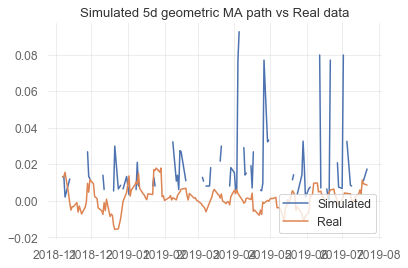

In [14]:
# Let's plot a generated sample against a real geometric time series curve
fig, ax = plt.subplots()
ax.plot(geoMA_5d_stocks_p1_T.columns, sim_paths_matrix[0], label = 'Simulated')
ax.plot(geoMA_5d_stocks_p1_T.columns, geoMA_5d_stocks_p1_T.iloc[random_tickers_selected[0]], label = 'Real')
ax.set_title('Simulated 5d geometric MA path vs Real data')
Legend = ax.legend(loc='lower right')

## Create a training and test dataset
Before building the VAE model, create the training and test sets (using a 80%-20% ratio):

In [15]:
# We shuffle the generated curves
shuffled_array = np.random.permutation(sim_paths_matrix)

The training set will be 80% of the simulated paths.

In [34]:
# We split the simulated time series into a training and test set
x_train = shuffled_array[0:8000]
x_test = shuffled_array[8000:]
# We split the simulated time series into a training and test set
x_train = shuffled_array[0:400]
x_test = shuffled_array[-400:]

In [35]:
print(x_train.shape)
print(x_test.shape)

(400, 175)
(400, 175)


# Variational Autoencoder Model

We will use a variational autoencoder to reduce the dimensions of a time series vector with 388 items to a two-dimensional point.
Autoencoders are unsupervised algorithms used to compress data. They are built with an encoder, a decoder and a loss function to measure the information loss between the compressed and decompressed data representations.

The encoder model has:
* One input vector of the dataset length
* One intermediate layer of length 300 with a rectified linear unit (ReLu) activation function
* One encoder with two dimensions.

In [36]:
# network parameters
original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10

Then we map inputs to the latent distribution parameters:

In [37]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We then use those parameters to sample new points from the latent space:

In [38]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [39]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

We instantiate the encoder model:

In [40]:
encoder = Model(inputs, z_mean)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 175)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               52800     
_________________________________________________________________
z_mean (Dense)               (None, 2)                 602       
Total params: 53,402
Trainable params: 53,402
Non-trainable params: 0
_________________________________________________________________


The decoded model has:
* One input vector of two dimensions (sampled from the latent variables)
* One intermediate layer of length 300 with a rectified linear unit (ReLu) activation function
* The decoded vector of the dataset length with a sigmoid activation function.

In [41]:

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

We instantiate the decoder model:

In [42]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               900       
_________________________________________________________________
dense_6 (Dense)              (None, 175)               52675     
Total params: 53,575
Trainable params: 53,575
Non-trainable params: 0
_________________________________________________________________


We instantiate the VAE model:

In [43]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

As in the Keras tutorial, we define a custom loss function:

In [44]:
def vae_loss(x, x_decoded_mean):
    xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

We compile the model:

In [45]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

## Train the model

In [46]:
results = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 0s 499us/step - loss: nan - val_loss: nan
Epoch 2/10
400/400 [==============================] - 0s 42us/step - loss: nan - val_loss: nan
Epoch 3/10
400/400 [==============================] - 0s 44us/step - loss: nan - val_loss: nan
Epoch 4/10
400/400 [==============================] - 0s 44us/step - loss: nan - val_loss: nan
Epoch 5/10
400/400 [==============================] - 0s 44us/step - loss: nan - val_loss: nan
Epoch 6/10
400/400 [==============================] - 0s 43us/step - loss: nan - val_loss: nan
Epoch 7/10
400/400 [==============================] - 0s 43us/step - loss: nan - val_loss: nan
Epoch 8/10
400/400 [==============================] - 0s 49us/step - loss: nan - val_loss: nan
Epoch 9/10
400/400 [==============================] - 0s 44us/step - loss: nan - val_loss: nan
Epoch 10/10
400/400 [==============================] - 0s 44us/step - loss: nan - val_loss: nan


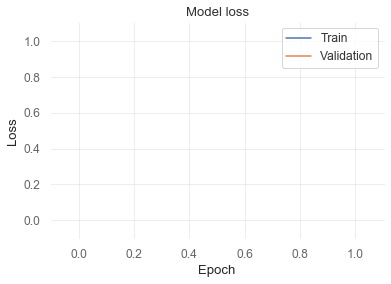

In [47]:
import ron.ai.keras as rk
rk.plot_training_results(results)

## Get predictions
We will only use the encoder to obtain the predictions. We will use a matrix of real values including both the stock dataset and one or multiple time series of interest.

#### Then divide the target dataset into two periods as well

In [40]:
geoMA_5d_target_p1 = target_gmean_5d.head(int(len(target_gmean_5d)/2))
geoMA_5d_target_p2 = target_gmean_5d.tail(int(len(target_gmean_5d)/2))
print('len(geoMA_5d_target_p1) =', len(geoMA_5d_target_p1))
print('len(geoMA_5d_target_p2) =', len(geoMA_5d_target_p1))

len(geoMA_5d_target_p1) = 1086
len(geoMA_5d_target_p2) = 1086


### Create the matrices to test (for period 1)

In [41]:
dataframe_to_test_p1 = geoMA_5d_stocks_p1.join(geoMA_5d_target_p1)

In [42]:
dataframe_to_test_p1.tail()

,AAPL,NKE,CSCO,IBM,JNJ,INTC,JPM,UNH,PG,DIS,...,WBA,MMM,GS,UTX,CVX,PFE,BA,WMT,VZ,DJI
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-13,-0.003901,0.006373,0.000028,0.004028,0.002138,0.002179,-0.001317,-0.004432,0.002658,-0.002230,...,0.002607,0.006841,-0.002037,0.004957,0.001122,-0.003054,0.000707,0.004716,0.002541,NaN
2019-02-14,0.000678,0.005444,0.007113,0.004850,0.003371,0.006256,0.000031,-0.002912,0.002680,-0.000572,...,0.003701,0.006300,-0.000605,0.006744,0.001850,0.001251,0.002257,0.003636,0.001694,NaN
2019-02-15,-0.000002,0.007168,0.009221,0.006326,0.005890,0.011187,0.008007,0.006808,0.001552,0.001854,...,0.010424,0.010115,0.006896,0.009560,0.004960,0.000768,0.006302,0.009016,0.004391,NaN
2019-02-19,0.001753,0.002074,0.008461,0.006878,0.005477,0.010454,0.008257,0.010004,0.003437,0.007283,...,0.012137,0.008584,0.007426,0.010564,0.005976,0.004356,0.005954,0.012084,0.005034,NaN
2019-02-20,0.001322,0.000276,0.007075,0.002815,0.003215,0.005416,0.005853,0.004469,0.000006,0.008027,...,0.001692,0.003186,0.004087,0.008182,0.004600,0.001544,0.005162,0.005795,0.004821,NaN


In [43]:
matrix_to_test_p1 = dataframe_to_test_p1.T.values

### Obtain the predictions (for period 1)

In [44]:
encoded_p1 = encoder.predict(matrix_to_test_p1, batch_size=batch_size)

# Convert the predictions into a dataframe
encoded_p1_df = pd.DataFrame(data = encoded_p1, columns = ['x','y'], index = dataframe_to_test_p1.T.index)

In [45]:
encoded_p1_df.tail()

,x,y
PFE,NaN,NaN
BA,NaN,NaN
WMT,NaN,NaN
VZ,NaN,NaN
DJI,NaN,NaN


#### Calculate the distances between the futures contract point and all other points in the stocks dataset

In [46]:
ref_point = encoded_p1_df.loc['Futures'].values
encoded_p1_df['Distance'] = scipy.spatial.distance.cdist([ref_point], encoded_p1_df, metric='euclidean')[0]

KeyError: 'Futures'

#### Get the 50 closest points to the Futures point

In [98]:
closest_points = encoded_p1_df.sort_values('Distance', ascending = True)
closest_points_top50 = closest_points.head(51)[1:] #We take head(51), because the Futures reference point is the first entry
closest_points_top50['Ticker'] = closest_points_top50.index

In [99]:
closest_points_top50.head()

,x,y,Distance,Ticker
CAEF,0.057430,-0.047858,0.000116,CAEF
FGDG,0.057383,-0.047626,0.000120,FGDG
EHDF,0.057339,-0.047642,0.000126,EHDF
HAAB,0.057502,-0.047864,0.000150,HAAB
GHFD,0.057549,-0.047922,0.000224,GHFD


#### Plot the results

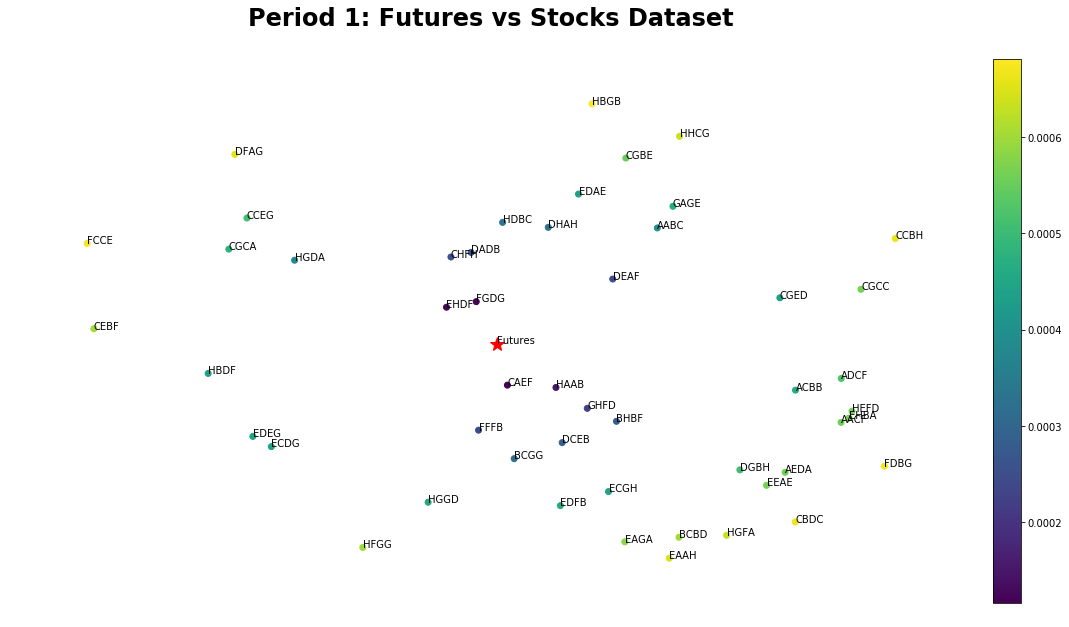

In [100]:
x_i = closest_points_top50['x']*1000
y_i = closest_points_top50['y']*100
d_i = closest_points_top50['Distance']
ticker_i = closest_points_top50['Ticker']
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.scatter(x_i, y_i, c = d_i, cmap = 'viridis')
plt.plot(ref_point[0]*1000, ref_point[1]*100,'r*', markersize = 15)
ax.annotate('Futures',(ref_point[0]*1000, ref_point[1]*100))
plt.colorbar(im, ax=ax)
plt.axis('off')
ax.set_title('Period 1: Futures vs Stocks Dataset\n', fontsize = 24, fontweight='bold')
for i, txt in enumerate(ticker_i):
    ax.annotate(txt, (x_i[i], y_i[i]))

# Application: Index construction

We will use the process described above to create an index.
Due to the randomness of the VAE model, we will not obtain the same exact list of top 50 stocks on each run.

To make sure that we get a fair representation of the closest 50 points, we will run the VAE model 10 times (re-initializing and retraining it on each run). Then we will take the 50 closest points found on each run to create a dataframe ***closest_points_df*** dataframe of length 500. 

In [101]:
from datetime import date

## Build the *closest_points_df* dataframe

In [102]:
today = date.today()
today_string = str(today.year)+str(today.month)+str(today.day)
n_trials = 10
path = PATH_FILES + '/Trial_outputs/' #The path should exist prior to execution.

# network parameters
original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10

for i in range(n_trials): # Create the VAE model and get the predictions n_trials(=10) times.
  n_rows_sim_paths_matrix = n_tickers_selected * n_simpath_per_ticker
  sim_paths_matrix  = np.zeros((n_rows_sim_paths_matrix, len(geoMA_5d_stocks_p1_T.iloc[0])))
  for j in range(len(random_tickers_selected)):
    random_index = random_tickers_selected[j]
    rd_stock_logReturns = np.diff(np.log(geoMA_5d_stocks_T.iloc[random_index]))
    for k in range(n_simpath_per_ticker):
      sim_path = np.zeros(len(geoMA_5d_stocks_p1_T.iloc[random_index]))
      sim_path[0] = geoMA_5d_stocks_p1_T.iloc[random_index][0]
      for l in range(1,len(sim_path)):
        sim_path[l] = sim_path[0]*np.exp(rd_stock_logReturns[np.random.randint(0, len(rd_stock_logReturns))])
      sim_paths_matrix[j*100+k] = sim_path
   
  shuffled_array = np.random.permutation(sim_paths_matrix)
  
  x_train = shuffled_array[0:8000]
  x_test = shuffled_array[8000:]

  # VAE model = encoder + decoder
  # build encoder model
  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)
  
  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary with the TensorFlow backend
  z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
  
  # instantiate encoder model
  encoder = Model(inputs, z_mean)
  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = Dense(original_dim, activation='sigmoid')(x)
  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  # instantiate VAE model
  outputs = decoder(encoder(inputs))
  vae = Model(inputs, outputs, name='vae_mlp')

  vae.compile(optimizer='rmsprop', loss=vae_loss)

  results = vae.fit(x_train, x_train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, x_test))

  encoded_p1 = encoder.predict(matrix_to_test_p1, batch_size=batch_size)
  # Convert the predictions into a dataframe
  encoded_p1_df = pd.DataFrame(data = encoded_p1, columns = ['x','y'], index = dataframe_to_test_p1.T.index)


  ref_point = encoded_p1_df.loc['Futures'].values
  encoded_p1_df['Distance'] = scipy.spatial.distance.cdist([ref_point], encoded_p1_df, metric='euclidean')[0]
  closest_points = encoded_p1_df.sort_values('Distance', ascending = True)
  closest_points_top50 = closest_points.head(51)[1:] #We take head(51), because the Futures reference point is the first entry
  closest_points_top50['Ticker'] = closest_points_top50.index
  
  # Save the top 50 closest points obtained for the cuurent run in a .xlsx file
  loop_currentfilename = path + 'Futures_vs_stocks_period1_'+today_string+'_trial_'+str(i+1)+'.xlsx'
  closest_points_top50.to_excel(loop_currentfilename)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 154us/step - loss: 1.1214 - val_loss: 0.4907
Epoch 2/10
8000/8000 [==============================] - 1s 89us/step - loss: 0.3271 - val_loss: 0.2636
Epoch 3/10
8000/8000 [==============================] - 1s 130us/step - loss: 0.1512 - val_loss: 0.0936
Epoch 4/10
8000/8000 [==============================] - 1s 130us/step - loss: 0.1096 - val_loss: 0.1553
Epoch 5/10
8000/8000 [==============================] - 1s 133us/step - loss: 0.0862 - val_loss: 0.0518
Epoch 6/10
8000/8000 [==============================] - 1s 125us/step - loss: 0.0692 - val_loss: 0.0552
Epoch 7/10
8000/8000 [==============================] - 1s 131us/step - loss: 0.0587 - val_loss: 0.0402
Epoch 8/10
8000/8000 [==============================] - 1s 124us/step - loss: 0.0515 - val_loss: 0.0444
Epoch 9/10
8000/8000 [==============================] - 1s 130us/step - loss: 0.0456 - val_loss: 0.0510
Epoch 10/10
8000/

8000/8000 [==============================] - 1s 153us/step - loss: 0.1044 - val_loss: 0.0645
Epoch 7/10
8000/8000 [==============================] - 1s 150us/step - loss: 0.0767 - val_loss: 0.0773
Epoch 8/10
8000/8000 [==============================] - 1s 149us/step - loss: 0.0613 - val_loss: 0.0545
Epoch 9/10
8000/8000 [==============================] - 1s 146us/step - loss: 0.0552 - val_loss: 0.0540
Epoch 10/10
8000/8000 [==============================] - 1s 140us/step - loss: 0.0512 - val_loss: 0.0395
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 189us/step - loss: 1.1076 - val_loss: 0.4225
Epoch 2/10
8000/8000 [==============================] - 1s 137us/step - loss: 0.4148 - val_loss: 0.2211
Epoch 3/10
8000/8000 [==============================] - 1s 135us/step - loss: 0.2447 - val_loss: 0.2000
Epoch 4/10
8000/8000 [==============================] - 1s 138us/step - loss: 0.1612 - val_loss: 0.1386
Epoch 5/10
8000/8000 [====

### Build the dataframe using the excel files saved

In [103]:
results = os.listdir(PATH_FILES + '/Trial_outputs/')
results_df = pd.DataFrame()
for f in results:
  path = PATH_FILES + '/Trial_outputs/'+str(f)
  data = pd.read_excel(path)
  results_df = results_df.append(data)

In [104]:
results_df.head()

,x,y,Distance,Ticker
BHBD,-0.118448,-0.126967,0.000203,BHBD
GBEA,-0.118013,-0.127155,0.000272,GBEA
FBCF,-0.118483,-0.127242,0.000275,FBCF
EFEH,-0.118375,-0.126793,0.000293,EFEH
ACGG,-0.118007,-0.126917,0.000303,ACGG


We sort all the points by distance (in ascending order)

In [105]:
sorted_by_dist = results_df.sort_values('Distance', ascending = True)

In [106]:
# We verify:
sorted_by_dist.head()

,x,y,Distance,Ticker
FADH,0.037527,-0.055782,0.000031,FADH
GBFC,0.037557,-0.055826,0.000067,GBFC
AFAG,-0.004665,0.020649,0.000072,AFAG
AFFD,-0.031613,-0.048004,0.000077,AFFD
EAGA,0.037523,-0.055678,0.000086,EAGA


In [107]:
len(sorted_by_dist)

500

We drop the duplicate tickers, keeping only the first occurance.

In [108]:
sorted_by_dist.drop_duplicates(subset='Ticker', keep='first', inplace = True)

In [109]:
len(sorted_by_dist)

256

## Compute the weights of each stock

We calculate the weight of each stock such that the points closest to the futures contract point will get a higher weight than the ones further from it.

With non anonymized stock data, it is important to filter the results obtained to keep the market capitalization range we want and to also remove outliers (stocks that are not related to the futures contract)  before computing the index weights.

In [110]:
# Calculate the weights
top50 = sorted_by_dist.head(50)
top50['Weight'] = (1/top50['Distance'])/np.sum(1/top50['Distance'])

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
top50.head()

,x,y,Distance,Ticker,Weight
FADH,0.037527,-0.055782,0.000031,FADH,0.102364
GBFC,0.037557,-0.055826,0.000067,GBFC,0.047425
AFAG,-0.004665,0.020649,0.000072,AFAG,0.044649
AFFD,-0.031613,-0.048004,0.000077,AFFD,0.041763
EAGA,0.037523,-0.055678,0.000086,EAGA,0.037321


## Determine the number of shares of each ticker

### Load the stock data

In [112]:
stock_data = pd.read_excel(PATH_FILES + '/stocks_data.xlsx')

# Remove the weekend and holidays
# We will use a well known stock (anonymized ticker: 'EAGH') as our reference data to detect weekends and public holidays
stock_data = stock_data[pd.notnull(stock_data['EAGH'])]

#After removing weekend and holidays, we clean the data further by removing columns which still contains NaN values
#Drop tickers for which there are NaN values
stock_data.dropna(axis='columns', inplace = True)

# We further drop all rows with 0
stock_data = stock_data[(stock_data != 0)]

#Get the stock prices for the top 50 stocks we selected
stock_data_top50 = stock_data[top50['Ticker']]

In [113]:
#Get the stock prices on January 4th 2016

jan4_2016_stockPrice = np.zeros(len(stock_data_top50.columns))
for i in range(len(jan4_2016_stockPrice)):
  if stock_data_top50.columns[i] == top50['Ticker'].iloc[i]:
    jan4_2016_stockPrice[i] = stock_data_top50[stock_data_top50.columns[i]].iloc[0]

In [114]:
top50['Price Jan4_2016'] = jan4_2016_stockPrice

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
top50.head()

,x,y,Distance,Ticker,Weight,Price Jan4_2016
FADH,0.037527,-0.055782,0.000031,FADH,0.102364,61.00
GBFC,0.037557,-0.055826,0.000067,GBFC,0.047425,61.00
AFAG,-0.004665,0.020649,0.000072,AFAG,0.044649,28.00
AFFD,-0.031613,-0.048004,0.000077,AFFD,0.041763,91.60
EAGA,0.037523,-0.055678,0.000086,EAGA,0.037321,9.56


### Compute the number of shares

In [116]:
net_assets = 10000000 # We chose net assets = 10 million (in the currency of the stock market)

numShares = np.zeros(len(stock_data_top50.columns))
for i in range(len(jan4_2016_stockPrice)):
  if stock_data_top50.columns[i] == top50['Ticker'].iloc[i]:
    numShares[i] = int(net_assets*top50['Weight'].iloc[i]/top50['Price Jan4_2016'].iloc[i])
    
top50['numShares'] = numShares

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [117]:
top50.head()

,x,y,Distance,Ticker,Weight,Price Jan4_2016,numShares
FADH,0.037527,-0.055782,0.000031,FADH,0.102364,61.00,16780.0
GBFC,0.037557,-0.055826,0.000067,GBFC,0.047425,61.00,7774.0
AFAG,-0.004665,0.020649,0.000072,AFAG,0.044649,28.00,15946.0
AFFD,-0.031613,-0.048004,0.000077,AFFD,0.041763,91.60,4559.0
EAGA,0.037523,-0.055678,0.000086,EAGA,0.037321,9.56,39039.0


## Construct the index

To construct the index, we will use the Laspeyres index method which is described in the S&P Dow Jones Indices [Index Mathematics Methodology](https://us.spindices.com/documents/methodologies/methodology-index-math.pdf ).

In [118]:
stock_index = np.zeros(len(stock_data_top50))

for i in range(len(stock_data_top50)):
  sum_num = 0
  sum_denom = 0
  for j in range(len(stock_data_top50.columns)):
    sum_num = sum_num + stock_data_top50[stock_data_top50.columns[j]].iloc[i]*top50['numShares'].iloc[j]
    sum_denom = sum_denom + stock_data_top50[stock_data_top50.columns[j]].iloc[0]*top50['numShares'].iloc[j]
  stock_index[i] = sum_num /sum_denom

In [119]:
stock_index_df = pd.DataFrame(stock_index*100, columns =  ['stock_index'], index = stock_data_top50.index)

We arbitrarily start the index at 100.

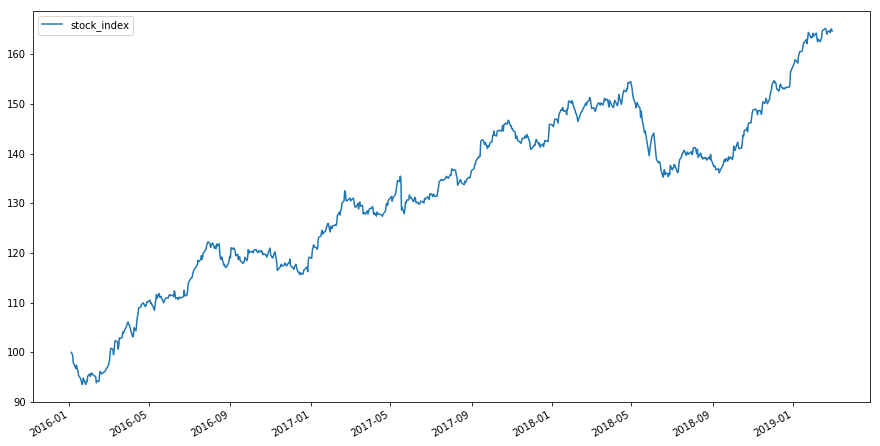

In [120]:
stock_index_df.plot(figsize=(15,8))

## Let's compare our index with the futures contract time series

### Get the futures data

In [121]:
futures_data = pd.read_excel(PATH_FILES + '/futures_data_frontMonth.xlsx', index_col = 0)
futures_data.index = pd.to_datetime(futures_data.index) #Convert the index to a datetime index
futures_data.sort_index(inplace = True)

# Only keep values that are also in stock_data dataframe and drop NaN values
futures_data_stock_data = futures_data.loc[futures_data.index.isin(stock_data.index)].dropna()
# We further drop all rows with 0
futures_data = futures_data_stock_data[(futures_data_stock_data != 0)]

In [122]:
#Then, we update the myIndex dataframe to make it have the same index as in the "Commodities" dataframe created above
stock_index_df = stock_index_df[stock_index_df.index.isin(futures_data.index)]

In [123]:
futures_data_stock_data_pct_change = futures_data_stock_data.pct_change()
futures_data_stock_data_pct_change.dropna(inplace = True)

In [124]:
futures_data_stock_data_pct_change.head()

,Settle
Date,
2016-01-05,0.002274
2016-01-06,-0.003176
2016-01-07,-0.010242
2016-01-08,-0.001495
2016-01-11,-0.021879


### Scale the time series to the index such that futures_theoretical[0] = stock_index[0] = 100

In [125]:
futures_theoretical = np.zeros(len(stock_index_df))
futures_theoretical[0] = stock_index_df.iloc[0]
for i in range(len(futures_theoretical)-1):
  futures_theoretical[i+1] = (1+futures_data_stock_data_pct_change.iloc[i])*futures_theoretical[i]

In [126]:
stock_index_df['Futures'] = futures_theoretical

In [127]:
stock_index_df.head()

,stock_index,Futures
2016-01-04,100.000000,100.000000
2016-01-05,99.782524,100.227402
2016-01-06,99.457649,99.909039
2016-01-07,97.982095,98.885731
2016-01-08,97.645471,98.737919


### Plot the Futures index and the stock_index we created

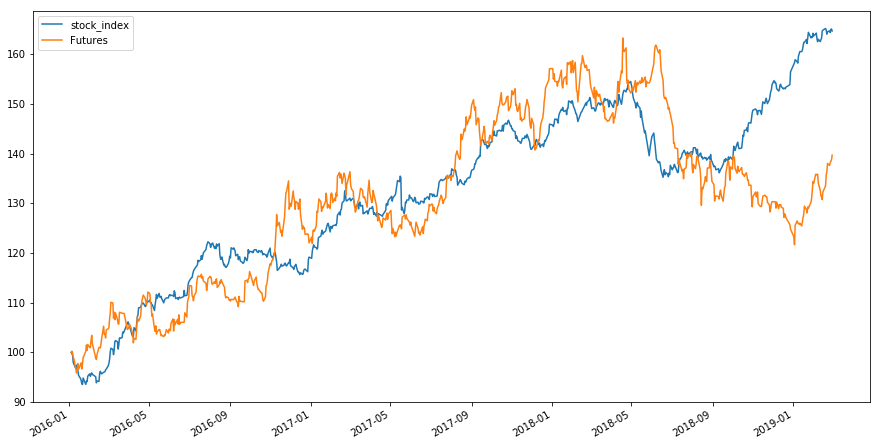

In [128]:
stock_index_df.plot(figsize=(15,8))

# Conclusion

Our index has mostly the same trend as the reference futures data except for the second half of 2018. Because we use anonymized data, we did not filter the stocks for outliers and market capitalization limits. Furthermore there was no re-balancing throughout the two time periods observed and we ignored distributions.


We believe that the use of variational autoencoders to construct an index can speed up the development of new indices in a stock market for which analysts may not be familiar with. Furthermore, it could help create even more niche indices to be used by ETFs or even new creative investment possibilities for direct indexing firms worldwide.